In [2]:
import pandas as pd
import seaborn as sn
import numpy as np
import matplotlib.pyplot as plt

from termcolor import colored

In [74]:

# numpy.random.gamma(shape, scale=1.0, size=None)
size = 10000

# Tworze sobie 4 rozne rozklady gamma:

Gamma_dict = {
    "Gamma_shape=2.0_scale=1.0":np.random.gamma(shape=2.0, scale=1.0, size=size),
    "Gamma_shape=2.0_scale=2.0":np.random.gamma(shape=2.0, scale=2.0, size=size),
    "Gamma_shape=4.0_scale=1.0":np.random.gamma(shape=4.0, scale=1.0, size=size),
    "Gamma_shape=4.0_scale=2.0":np.random.gamma(shape=4.0, scale=2.0, size=size)
}

# i robie z nich dataframe:
dataFrameGamma = pd.DataFrame.from_dict(Gamma_dict)

# i wykonuje operacje melted:
meltedGamma = dataFrameGamma.melt()

# Teraz mam przygotowane dane wyswietlenia histogramow

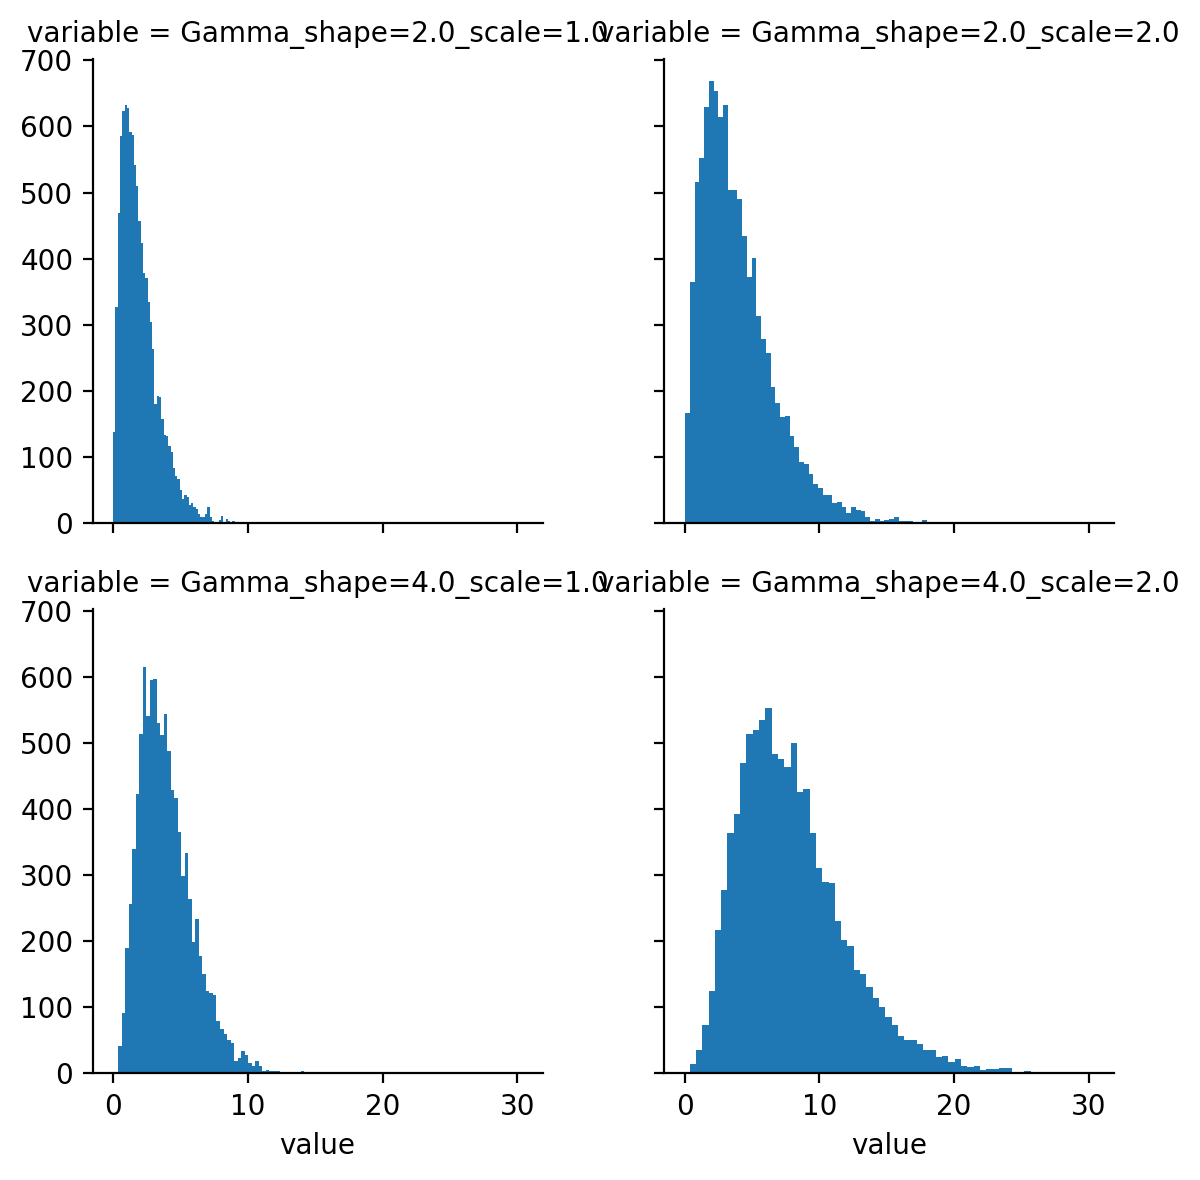

In [75]:
# Wygenerowanie histogramow rozkladow gamma:

Visualization = sn.FacetGrid(meltedGamma, col="variable", sharex=True, col_wrap=2)
Visualization.map(plt.hist, "value", cumulative=False, bins=64)
    

In [76]:
# Zaladuje jeszcze moduly do wyswietlania wykresow gestosci rozkladu prawdopodobienstwa

import scipy.stats as stats
import matplotlib as mpl

# Pare ustawien dla kolorow i wykresow z wykladow:

light="#FFFCDC"
light_highlight="#FEF590"
mid="#FDED2A"
mid_highlight="#f0dc05"
dark="#EECA02"
dark_highlight="#BB9700"
green="#00FF00"
blue="#0000FF"
red="#FF0000"
light_grey="#DDDDDD"

plt.style.context('seaborn-white')
mpl.rcParams['figure.dpi']= 200

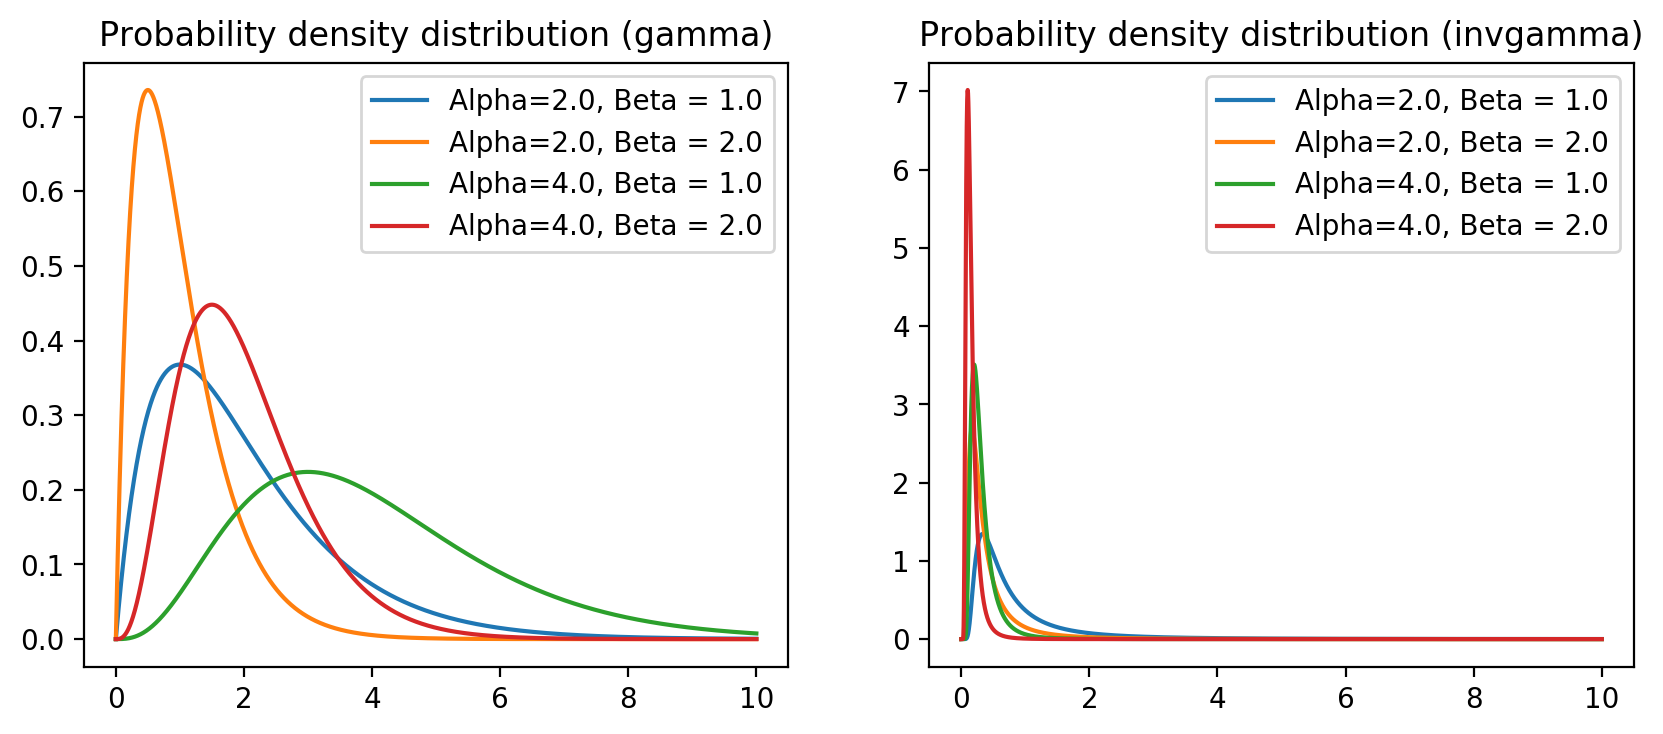

In [77]:
# Nowy figure dla wykresiku
plt.figure(figsize=(10,4))

# Tworze os X od 0 do 10 i liczbie 10k punktow
x_axis = np.linspace(0,10,10000)

# Tworze rozkladziki gamma o takich parametrach jak do histogramow, bo moge
a, beta = 2, 1
Gamma_alpha_2_beta_1 = stats.gamma.pdf(x_axis, a=a, scale=1/beta)
Gamma_alpha_2_beta_1_inv = stats.invgamma.pdf(x_axis, a=a, scale=1/beta)
a, beta = 2, 2
Gamma_alpha_2_beta_2 = stats.gamma.pdf(x_axis, a=a, scale=1/beta)
Gamma_alpha_2_beta_2_inv = stats.invgamma.pdf(x_axis, a=a, scale=1/beta)
a, beta = 4, 1
Gamma_alpha_4_beta_1 = stats.gamma.pdf(x_axis, a=a, scale=1/beta)
Gamma_alpha_4_beta_1_inv = stats.invgamma.pdf(x_axis, a=a, scale=1/beta)
a, beta = 4, 2
Gamma_alpha_4_beta_2 = stats.gamma.pdf(x_axis, a=a, scale=1/beta)
Gamma_alpha_4_beta_2_inv = stats.invgamma.pdf(x_axis, a=a, scale=1/beta)

# Wyswietlam na jednym zwykly rozklad prawdopodobienstwa gamma
plt.subplot(1,2,1)
plt.plot(x_axis, Gamma_alpha_2_beta_1, label="Alpha=2.0, Beta = 1.0")
plt.plot(x_axis, Gamma_alpha_2_beta_2, label="Alpha=2.0, Beta = 2.0")
plt.plot(x_axis, Gamma_alpha_4_beta_1, label="Alpha=4.0, Beta = 1.0")
plt.plot(x_axis, Gamma_alpha_4_beta_2, label="Alpha=4.0, Beta = 2.0")
plt.legend()
plt.title("Probability density distribution (gamma)")

# Wyswietlam na drugim rozklad prawdopodobienstwa inverted gamma
plt.subplot(1,2,2)
plt.plot(x_axis, Gamma_alpha_2_beta_1_inv, label="Alpha=2.0, Beta = 1.0")
plt.plot(x_axis, Gamma_alpha_2_beta_2_inv, label="Alpha=2.0, Beta = 2.0")
plt.plot(x_axis, Gamma_alpha_4_beta_1_inv, label="Alpha=4.0, Beta = 1.0")
plt.plot(x_axis, Gamma_alpha_4_beta_2_inv, label="Alpha=4.0, Beta = 2.0")
plt.legend()
plt.title("Probability density distribution (invgamma)")

# Na koniec pokazuje wykresiki
plt.show()


In [78]:
# Teraz zaladuje wszystkie potrzebne zabawki ze "stana"
import pystan
import stan_utility

# Otwieram pliczek z prior.stan zeby zobaczyc zawartosc:

with open('prior_gamma.stan', 'r') as file:
    print(file.read())

functions 
{
	vector tail_delta(vector y,       	// unknowns
                    vector theta,   	// parameters
                    real[] x_r,     	// data(real)
                    int[] x_i) 			// data(integer)
	{    
		vector[2] deltas;
		// At the end we will receive distribution from 5 to 10 with 98% probability
		deltas[1] = gamma_cdf(theta[1], y[1], y[2]) - 0.99;
		deltas[2] = gamma_cdf(theta[2], y[1], y[2]) - 0.01;
		return deltas;
	}
}

data 
{
	vector<lower=0>[2] y_guess; 	// Initial guess of Gaussian standard deviation
	vector<lower=0>[2] theta;   	// Target quantile
}

transformed data 
{
	vector[2] y;
	real x_r[0];
	int x_i[0];

	// Find gamma parameters that ensures 98% probabilty from 5 to 10
	y = algebra_solver(tail_delta, y_guess, theta, x_r, x_i, 1e-10, 1e-3, 1e3); 
	// last 3 parameters are tolerances, middle one was changed due to occuring error, not recomended solution but it works

	print("Alpha  = ", y[1]);
	print("Beta = ", y[2]);
}

generated quantities 
{
	re

In [79]:
# Tak jak na wykladzie, kompiluje model:
# TO MOZE POTRWAC!

model_prior = stan_utility.compile_model('prior_gamma.stan')

#Jakies 30 sekund i 1,8GB RAMu

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_15bd095239bd0e5ff098514498fa0237 NOW.


In [80]:
# Teraz sobie pozgadujemy:
# Musi byc dict bo takie sa wymagania stana, tak musi byc i tyle:
data = dict(y_guess = np.array([1, 0.1]), theta = np.array([10, 5]))

# No i tutaj robimy sobie sampling, zeby zobaczyc jakie dostaniemy wyniki
sampling_data = model_prior.sampling(data = data, seed = 11062020, algorithm = "Fixed_param", iter = 1, warmup = 0, chains = 1)

In [81]:
# Wyciagamy wyniki z naszego samplowania:

alpha, beta = np.round(sampling_data.extract()['alpha']), np.round(sampling_data.extract()['beta'])

print("Alpha: ")
print(alpha)
print("Beta: ")
print(beta)

Alpha: 
[46.]
Beta: 
[6.]


In [82]:
# Teraz stworze plik z modelem gamma dla stana, zeby mogl ladnie policzyc. Mozna napisac plik i go zapisac po ludzku, ale ja sobie napisalem w pythonie.

Gamma_stan_file = open("Gamma_distribution.stan", "w")

Gamma_stan_file.write("\
data \n\
{\n\
    real <lower = 0> alpha;\n\
    real <lower = 0> beta;\n\
}\n\
\n\
parameters\n\
{\n\
    real dane_wyjsciowe;\n\
}\n\
\n\
model\n\
{\n\
    dane_wyjsciowe ~ gamma(alpha, beta);\n\
}\n\
")

Gamma_stan_file.close()

In [83]:
# Teraz wykonamy kompilacje modelu gamma:

model_gamma = stan_utility.compile_model("Gamma_distribution.stan")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ec32cafd5da323bb4c3907c07f8e443b NOW.


In [84]:
# Teraz wykonamy sampling modelu gamma:

data = {'alpha': alpha[0], 'beta': beta[0]}
numberOfIterations = 10000

sampling_gamma = model_gamma.sampling(data = data, iter = numberOfIterations, chains = 1, seed = 11062020)

(array([ 1.,  3.,  0.,  1.,  3.,  1.,  1.,  1.,  1.,  2.,  5.,  4.,  7.,
         5.,  6.,  3.,  3.,  8.,  9.,  6.,  5.,  7., 11., 12., 13., 11.,
        10., 15., 24., 17., 14., 33., 14., 31., 27., 28., 39., 24., 25.,
        26., 31., 35., 45., 48., 55., 47., 38., 49., 41., 36., 40., 49.,
        43., 46., 64., 60., 49., 60., 62., 67., 54., 70., 60., 63., 61.,
        59., 54., 60., 82., 57., 69., 70., 86., 63., 58., 86., 48., 71.,
        67., 63., 63., 75., 73., 59., 57., 66., 72., 68., 52., 57., 70.,
        54., 51., 50., 50., 56., 46., 52., 41., 58., 36., 38., 41., 50.,
        39., 40., 38., 39., 39., 20., 34., 27., 38., 45., 30., 28., 24.,
        23., 27., 30., 28., 15., 15., 22., 21., 20., 20., 12., 15., 17.,
        15., 16.,  7., 14., 10., 13.,  9.,  9.,  4.,  8.,  6.,  9.,  2.,
        10.,  9.,  9.,  6.,  6.,  3.,  5.,  4.,  5.,  8.,  4.,  3.,  3.,
         2.,  1.,  3.,  1.,  2.,  1.,  1.,  3.,  1.,  3.,  4.,  1.,  2.,
         5.,  1.,  3.,  0.,  1.,  2.,  0.,  1.,  1.

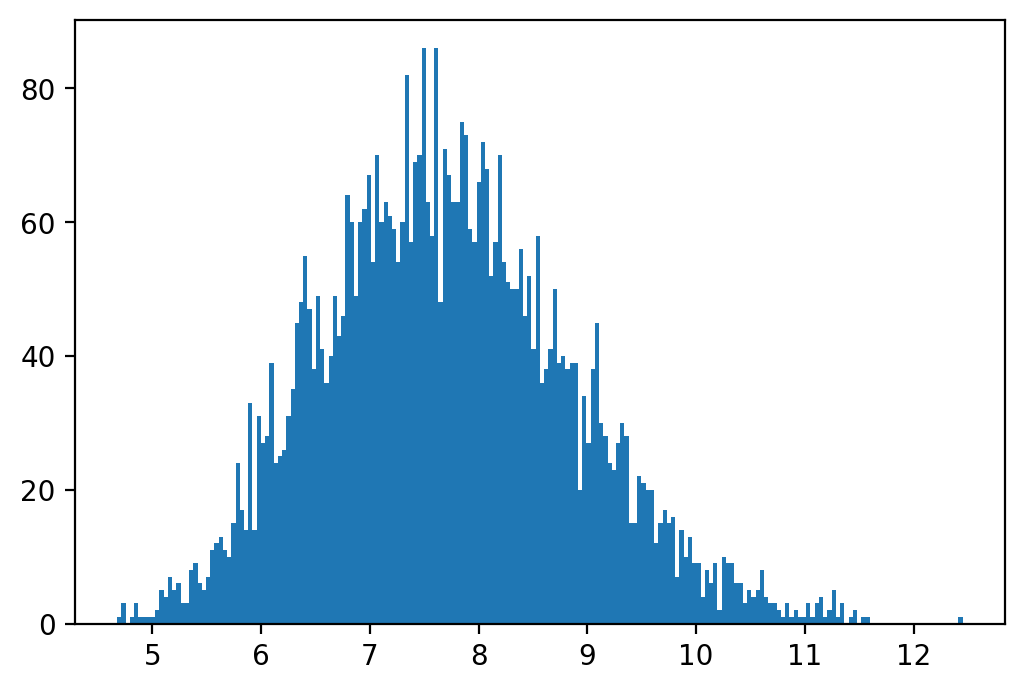

In [85]:
# A teraz wyswietle sobie dane ktore otrzymalem i zobaczymy co nam wyszlo

gamma_distribution = sampling_gamma.extract()
plt.hist(gamma_distribution['dane_wyjsciowe'], bins=200)

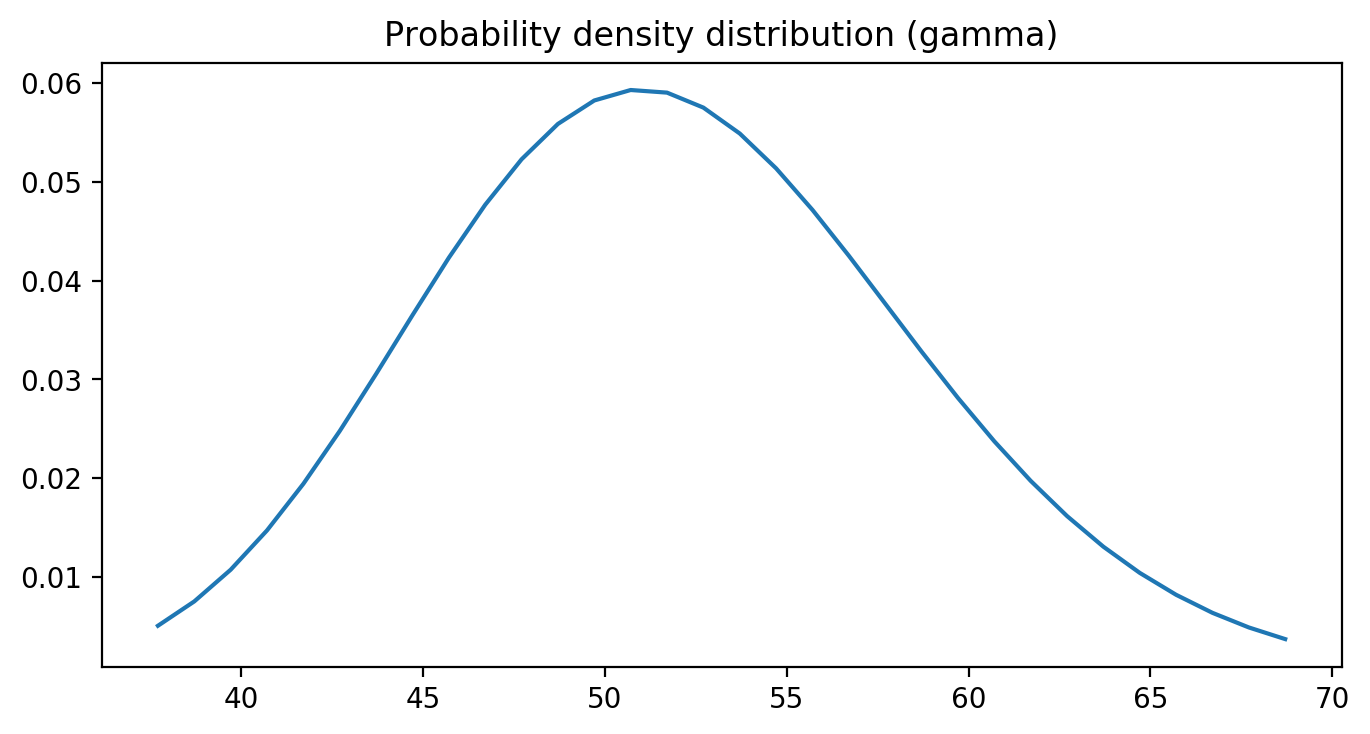

In [86]:
# Nowy figure dla wykresiku
plt.figure(figsize=(8,4))

# Robimy sobie os x od 1 do 99 %
x_axis = np.arange(stats.gamma.ppf(0.01, alpha, beta), stats.gamma.ppf(0.99, alpha, beta))

# Robimy sobie rozkladzik na tej osi
Gamma_dist = stats.gamma.pdf(x_axis, alpha, beta)

# Wyswietlam rozklad prawdopodobienstwa gamma
plt.plot(x_axis, Gamma_dist)

plt.title("Probability density distribution (gamma)")

# Na koniec pokazuje wykresiki
plt.show()

# No i cos tu nie dziala bo mialo byc 98% wartosci od 5 do 10!!!!!

In [87]:
# Tak jak na wykladzie, kompiluje model dla gamma inv:
# TO MOZE POTRWAC!

model_prior_inv = stan_utility.compile_model('prior_gamma_inv.stan')


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d1599278f47d107e2bbb890771f72ebd NOW.


In [88]:
# Teraz sobie pozgadujemy:
# Musi byc dict bo takie sa wymagania stana, tak musi byc i tyle:
data = dict(y_guess = np.array([0.15, 0.15]), theta = np.array([10, 5]))

# No i tutaj robimy sobie sampling, zeby zobaczyc jakie dostaniemy wyniki
sampling_data_inv = model_prior_inv.sampling(data = data, seed = 11062020, algorithm = "Fixed_param", iter = 1, warmup = 0, chains = 1)

In [89]:
# Wyciagamy wyniki z naszego samplowania:

alpha_inv, beta_inv = np.round(sampling_data_inv.extract()['alpha']), np.round(sampling_data_inv.extract()['beta'])

print("Alpha: ")
print(alpha_inv)
print("Beta: ")
print(beta_inv)

Alpha: 
[47.]
Beta: 
[320.]


In [90]:
# Teraz stworze plik z modelem gamma inv dla stana, zeby mogl ladnie policzyc. Mozna napisac plik i go zapisac po ludzku, ale ja sobie napisalem w pythonie.

Gamma_stan_file = open("Gamma_inv_distribution.stan", "w")

Gamma_stan_file.write("\
data \n\
{\n\
    real <lower = 0> alpha;\n\
    real <lower = 0> beta;\n\
}\n\
\n\
parameters\n\
{\n\
    real dane_wyjsciowe;\n\
}\n\
\n\
model\n\
{\n\
    dane_wyjsciowe ~ inv_gamma(alpha, beta);\n\
}\n\
")

Gamma_stan_file.close()

In [91]:
# Teraz wykonamy kompilacje modelu gamma inv:

model_gamma = stan_utility.compile_model("Gamma_inv_distribution.stan")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_b844f278c2b9861309a84d357908e337 NOW.


In [92]:
# Teraz wykonamy sampling modelu gamma inv:

data = {'alpha': alpha_inv[0], 'beta': beta_inv[0]}
numberOfIterations = 10000

sampling_gamma = model_gamma.sampling(data = data, iter = numberOfIterations, chains = 1, seed = 11062020)

(array([ 1.,  0.,  1.,  1.,  2.,  1.,  2.,  1.,  2.,  1.,  3.,  5.,  4.,
         5.,  4.,  7.,  6.,  6.,  5.,  6.,  5., 11., 10., 18., 14., 10.,
        19., 25., 18., 27., 20., 25., 19., 28., 27., 40., 27., 36., 23.,
        41., 45., 36., 46., 46., 54., 40., 64., 53., 55., 55., 72., 56.,
        65., 66., 55., 49., 73., 72., 65., 71., 69., 70., 72., 59., 75.,
        75., 86., 61., 58., 62., 70., 69., 76., 71., 60., 70., 74., 62.,
        71., 51., 69., 83., 67., 56., 60., 52., 55., 44., 58., 66., 52.,
        55., 36., 52., 41., 44., 44., 42., 41., 44., 36., 31., 33., 42.,
        36., 32., 42., 36., 27., 34., 35., 31., 24., 18., 18., 21., 19.,
        28., 18., 23., 16., 15., 13., 14., 19., 17., 15., 15., 11.,  7.,
        12., 11., 15.,  8.,  7.,  4.,  6., 10., 15.,  2.,  6., 14., 11.,
         3.,  2.,  9.,  6.,  5.,  3.,  8.,  3.,  4.,  5.,  4.,  3.,  1.,
         2.,  1.,  1.,  2.,  5.,  0.,  2.,  1.,  2.,  2.,  1.,  1.,  0.,
         0.,  2.,  1.,  0.,  0.,  0.,  1.,  0.,  2.

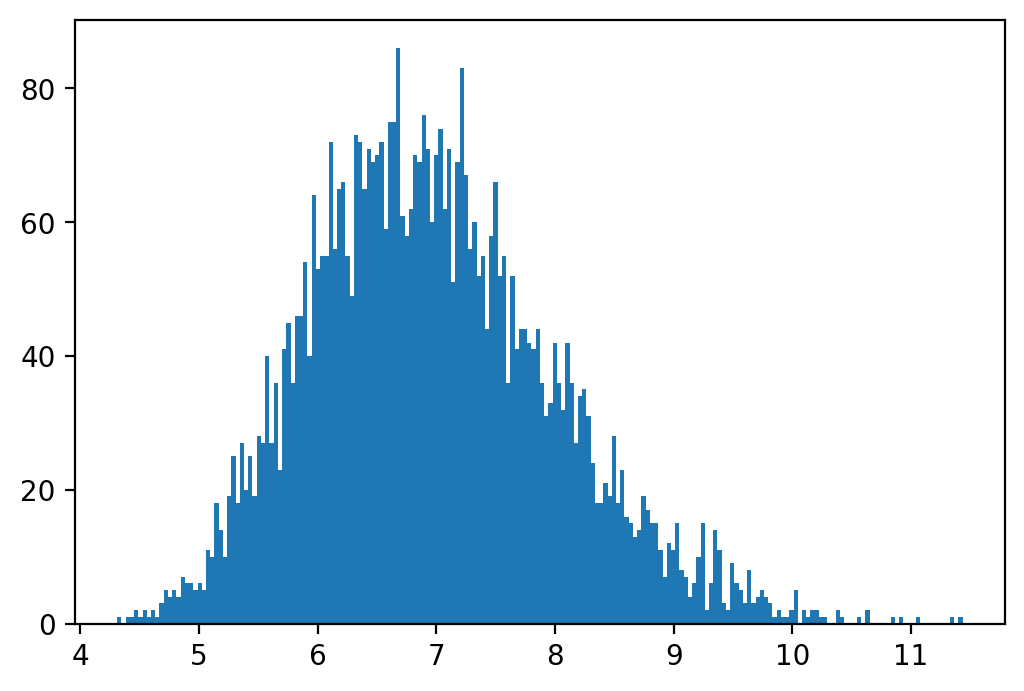

In [93]:
# A teraz wyswietle sobie dane ktore otrzymalem i zobaczymy co nam wyszlo

gamma_inv_distribution = sampling_gamma.extract()
plt.hist(gamma_inv_distribution['dane_wyjsciowe'], bins=200)

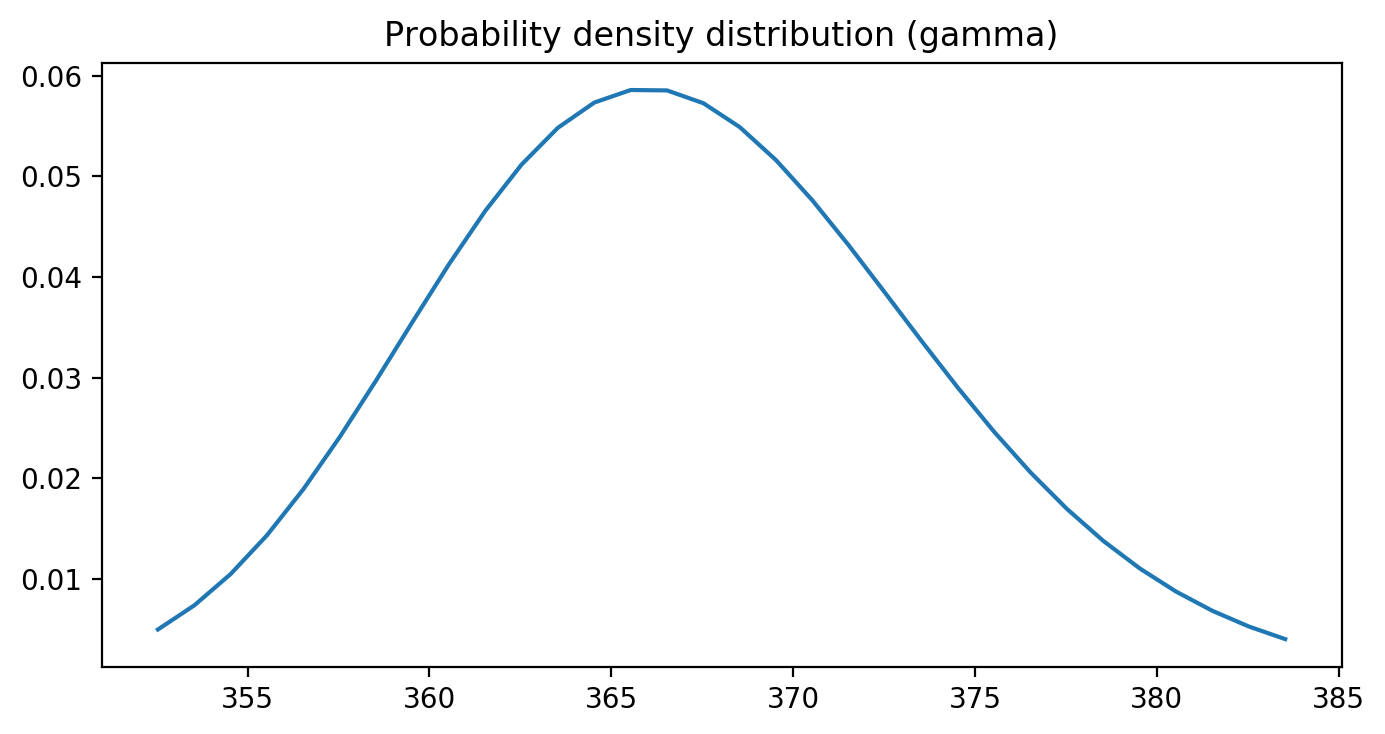

In [94]:
# Nowy figure dla wykresiku
plt.figure(figsize=(8,4))

# Robimy sobie os x od 1 do 99 %
x_axis = np.arange(stats.gamma.ppf(0.01, alpha_inv, beta_inv), stats.gamma.ppf(0.99, alpha_inv, beta_inv))

# Robimy sobie rozkladzik na tej osi
Gamma_dist = stats.gamma.pdf(x_axis, alpha_inv, beta_inv)

# Wyswietlam rozklad prawdopodobienstwa gamma
plt.plot(x_axis, Gamma_dist)

plt.title("Probability density distribution (gamma)")

# Na koniec pokazuje wykresiki
plt.show()

# I znow nie bardzo sie to zgadza z tym, co mielismy osiagnac!!!! Mialo byc cos takiego ale dla xe<5,10> !!!

In [3]:
# Wartosciowy komentarz:
print(colored("Obtained distributions are like identical, the little changes between them are almost invisible.", 'red'))

Obtained distributions are like identical, the little changes between them are almost invisible.
